# Tiles Splitter script
Script que permite el procesamiento en batch del dataset para dividir cada imagen y sus etiquetas en mosaicos de 'S' píxeles.

In [460]:
# Standard library imports
import math
import os
import re
import shutil
import sys
import unicodedata
import warnings
from itertools import product
from datetime import datetime

# Third-party library imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Helper functions

In [461]:
# Handy icons for user warnings
#  🆕🆗✅❌🚫⛔️❔❓❕❗️➕✔️📂📁🗃️🗄️⏸️🚨

### Security

In [462]:
# DECORATOR FOR INPUT SANITIZATION
# Safety Mesaures for verfying potential harmful user inputs

def remove_accents(input_str):
    """Replace accents from a string with equivalent letter, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn(f"Accents were removed from input. ('{original_str}' -> '{result}')", UserWarning)

    return result

def sanitize_filename(input_str):
    """Sanitizes a filename by removing accents and disallowed characters."""
    input_str = remove_accents(input_str)  # Remove accents first
    result = input_str

    # Checks for prohibited characters (then deletes them)
    # allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    allowed_chars = r"^[a-zA-Z0-9_\-\./]+$" # Allow '/' in user input
    if input_str and not re.fullmatch(allowed_chars, input_str):
        result = re.sub(allowed_chars, "", input_str)  # Sanitize (remove invalid chars)
        warnings.warn(f"This argument is unsafe. A sanitized version will be used instead. ('{input_str}' -> '{result}')", UserWarning)

    #if input_str == result:
    #    print("Original name: '", input_str)
    #    print("Sanitized name: '", result)
    #    print()

    return result

# Decorator wrapper
def validate_filenames():
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Arguments Sanitization 
            sanitized_args = []
            for arg in args:
                if isinstance(arg, str):
                    original_arg = arg
                    sanitized_arg = sanitize_filename(arg) # Sanitize argument
                    if sanitized_arg != original_arg:
                        warnings.warn(f"Argument '{original_arg}' sanitized to '{sanitized_arg}'.", UserWarning)
                else:
                    sanitized_arg = arg
                    # warnings.warn(f"Argument '{arg}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_args.append(sanitized_arg)

            # Keyword Arguments Sanitization 
            sanitized_kwargs = {}
            for key, value in kwargs.items():
                if isinstance(value, str):
                    original_value = value
                    sanitized_value = sanitize_filename(value) # Sanitize value for keyword
                    if sanitized_value != original_value:
                        warnings.warn(f"Keyword argument '{key}'='{original_value}' sanitized to '{sanitized_value}'.", UserWarning)
                else:
                    sanitized_value = value
                    # warnings.warn(f"Argument '{value}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_kwargs[key] = sanitized_value

            # Return sanitized arguments
            return func(*sanitized_args, **sanitized_kwargs)
        return wrapper
    return decorator


In [463]:
def timestamp(message=''):
    currenttime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if message:
        print(message, currenttime, sep=": ")
    else:
        print('Timestamp', currenttime, sep=": ")

### File management

In [464]:
@validate_filenames()
def create_dir(folder_path):
    # 1) Verifica si el directorio existe y confirma si es necesario vaciarlo
    if os.path.exists(folder_path):
        print(f"🚨ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.")
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el directorio '{folder_path}' y su contenido? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            shutil.rmtree(folder_path)  # Elimina el directorio y todo su contenido
            print("> Directorio eliminado:\n",folder_path)
        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()
    else:
        print("🆕 El directorio no existe, se creará uno nuevo:",{folder_path})
        
    # 2) Crea el directorio especificado
    os.makedirs(folder_path, exist_ok=True)
    print("✅ El directorio ya está disponible:\n",{folder_path})

In [465]:
@validate_filenames()
def empty_dir(folder_path):
    """
    Elimina todo el contenido (archivos y subdirectorios) de una carpeta especificada.

    Args:
        folder_path: La ruta de la carpeta que se va a limpiar.

    Raises:
        FileNotFoundError: Si la carpeta especificada no existe.
        OSError: Si ocurre un error durante la eliminación de archivos o directorios.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❗️La carpeta '{folder_path}' no existe.")

    try:
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el contenido de '{folder_path}'? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            for file in os.listdir(folder_path):  # Itera sobre los archivos y directorios
                file_path = os.path.join(folder_path, file)  # Crea la ruta completa

                if os.path.isfile(file_path):  # Si es un archivo
                    os.remove(file_path)  # Elimina el archivo
                    #print(f"Archivo eliminado: {file_path}")

                elif os.path.isdir(file_path):  # Si es un directorio
                    shutil.rmtree(file_path)  # Elimina el directorio y su contenido de forma recursiva
                    #print(f"Directorio eliminado: {file_path}")

            print("✔️ Contenido de la carpeta eliminado:\n", folder_path)

        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()

    except OSError as e:
        raise OSError(f"🚫 Error al limpiar la carpeta:\n {e}")    
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")

In [521]:
# MODIFIED FOR SINGLE IMAGES
@validate_filenames()
def build_filename(dset: str = '', dtype: str = '', dir: str='in', name: str | None = None, prefix: str = '', verbose: bool = False) -> str:
    """ 
    Construye el nombre y ruta necesaria para cargar/guardar cada archivo del dataset.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - dtype (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.
        - prefix (str): Establece un prefijo para el nombre del archivo (ej:'tile00x00.').
        - verbose (bool): Ofrece información verbal al usuario.

    Retorna:
        - str: Por defecto entrega la ruta de la carpeta (del dataset de entrada o salida).
        - Si además se incluye 'dset' o 'dtype', entrega el directorio de la subcarpeta correspondiente.
        - Si se incluye un nombre de archivo, devuelve la ruta con el formato adecuado.
    """
    
    # Function Example:
    #    - in: "/data/raw/3.5m.v3i.yolov8/valid/labels/
    #            209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - out: "/data/processed/3.5m.v3i.yolov8/valid/labels/
    #            tile00x00.209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - shape: /data/{dir}/{PATH}{dsuffix}/{dset}/{dtype}/ <- Folder path
    #             {prefix}.{filename}.{dtype}        <- Full filename

    # INITIALIZER LOGIC
    # Verifies that every input has the correct type
    assert (isinstance(name, str | None)
            and isinstance(dset, str)
            and isinstance(dtype, str)
            and isinstance(prefix, str)
            and isinstance(dir, str)), "❕All arguments must be strings."
    
    try:
        PATH
    except NameError:
        raise NameError("❗️ PATH constant is not defined.")
    try:
        OUTPUT_SUFFIX
    except NameError:
        raise NameError("❗️ OUTPUT_SUFFIX constant is not defined.")
    try:
        POINTER
    except NameError:
        raise NameError("❗️ POINTER constant is not defined.")
    
    # Normalize inputs
    dset = dset.lower()
    dtype = dtype.lower()
    dir = dir.lower()

    # This help splitting the name in half
    # for inserting the prefix next to photo filename (ej: 209_205_50_JPG)
    #POINTER = '.rf.' # could be modified for differente tag name formats
    if POINTER:
        pointer_idx = name.find(POINTER) if (name != None) else ""
    else:
        pointer_idx = -1
    
    # Default folders and extensions
    dset_map = {
        'train': 'train/',
        'valid': 'valid/',
        'test': 'test/',
        '': ''
    }
    # Handle both plural and singular inputs
    dtype_map = {
        'image': ('images', 'jpg'),
        'images': ('images', 'jpg'),
        'label': ('labels', 'txt'),
        'labels': ('labels', 'txt'),
        '': ('', ''),
    }

    def get_dset_path(dset_val: str) -> str:
        if dset_val not in dset_map:
            raise ValueError("❕Invalid 'dset': must be 'train', 'valid', or 'test'. \
                             (Empty by default)")
        return dset_map[dset_val]

    def get_dtype_info(dtype_val: str) -> tuple[str, str]:
        if dtype_val not in dtype_map:
            raise ValueError("❕Invalid 'type': must be 'image' or 'label'. \
                             (Empty by default)")
        return dtype_map[dtype_val]

    # FILENAME CREATION LOGIC
    # Output dataset logic
    if dir == 'out':
        if name is None or name == '':
            filename = ''
            print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
        else:
            name = f"{name}{OUTPUT_SUFFIX}"
                
        if output_dir:
            root = output_dir
        else:
            root = PATH.replace('raw','processed')

        #if OUTPUT_SUFFIX:
        #    root = f"{root[:-1]}{OUTPUT_SUFFIX}/"

        base_path = f"{root}{get_dset_path(dset)}" if dset else root
        
        if dtype:
            _, extension = get_dtype_info(dtype)
            #base_path = f"{base_path}{type_folder}/"
            base_path = f"{base_path}"
        else:
            _, extension = '',''

        print("✔️ Dataset root created successfully") if verbose else ""
        #return f"{base_path}{filename}" # Ending for 'out' option
    
    # Input dataset logic
    elif dir == 'in':
        root = PATH
        _, extension = get_dtype_info(dtype)
        #base_path = f"{root}{get_dset_path(dset)}{type_folder}/"
        base_path = f"{root}{get_dset_path(dset)}"
        
    else:
        raise ValueError("❕Invalid 'dir': must be 'in' (default) or 'out'.")
    
    # PREFIX LOGIC
    # Managing filename prefixes
    if name is None or name == '':
        filename = ''
        print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
    else:
        if not prefix:
            # If no prefix is defined, it keeps the original name
            filename = f"{name}.{extension}"
        else:
            if pointer_idx == -1:
                # When the reference in name format is not found, it adds the prefix at the end
                filename = f"{prefix}.{name}.{extension}"
                print(f"⚠ The original file does not follow the expected format."
                      f"Filenames should inlcude a '{POINTER}' reference inside.\n"
                      f"Therefore, the indicated prefix value '{prefix}' will be"
                      f"added at the end of the current filename.") if verbose else ''
            else:
                # If the format is ok, it inserts the prefix in between the original JPG filename and the hash part
                name_jpg = name[:pointer_idx]
                name_hash = name[pointer_idx:]
                filename = f"{name_jpg}.{prefix}{name_hash}.{extension}"
    
    #print("Input:", PATH, "Output:", root)
    print("✔️ Filename created succesfully") if verbose else ""
    return f"{base_path}{filename}"

In [467]:
def filenames_for_tiles(dset: str, dtype: str, dir: str='in', name: str | None = None) -> callable:
    """ 
    Crea una función anidada para generar nombres de archivo y ruta para cada mosaico.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - dtype (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.

    Retorna:
        - callable: Retorna la función generadora anidada.
    """
    def generate_filename(prefix: str = '') -> str:
        """
        Construye el nombre y ruta para el mosaico especificado.
        """
        return build_filename(dset=dset, dtype=dtype, dir=dir, prefix=prefix, name=name, verbose=False)

    return generate_filename  # Return the nested function

In [468]:
@validate_filenames()
def save_labels(dest_labels_file: str, export: pd.DataFrame, verbose: bool = True) -> bool:
    """
    Saves a DataFrame to a file, with each row as a space-separated string.

    Args:
        dest_labels_file: Path to the output file.
        export: DataFrame to save.

    Returns:
        True if the file was saved successfully, False otherwise.
    """
    try:
        lines = label_to_str(export)
        with open(dest_labels_file, 'w') as file:
            file.writelines(line + "\n" for line in lines)
        if verbose:
            print("El archivo de etiquetas se ha creado correctamente. Se han guardado todos los datos.")
        return True
    
    except OSError as e:
        raise OSError(f"🚫 Error al copiar la carpeta:\n {e}")
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")


### Formatting

In [469]:
def label_to_str(export: pd.DataFrame) -> list[str]:
    
    """
    Converts each row of a dataframe into string format

    Parameters:
    - Dataframe with labels (np.dataframe)

    Returns:
    - List with labels in text (list[str])
    """
    
    lines = []
    for _, row in export.iterrows():
        row_list = list(row)
        row_list[0] = int(row_list[0])
        line = ' '.join(map(str, row_list))
        lines.append(line)
        
    # Verificar que la cantidad de lineas coincide con la cantidad de labels
    if not len(lines) == len(export):
        raise ValueError("🚨 CUIDADO: el número de etiquetas en el archivo de salida y el dataframe no coinciden.")

    return lines

In [470]:
def get_index(row:int , column:int ) -> int:
    """
    Calcula el índice lineal en una estructura de datos de los mosaicos definidos en el setup inicial.

    Parámetros:
    - row: Número de fila (entero).
    - column: Número de columna (entero).

    Salida:
    - Índice lineal calculado. 
    """
    if not isinstance(COLUMNS, int):
        raise TypeError(f"❕La constante columna no está definida adecuadamente. (value:{COLUMNS})")
    if not isinstance(row, int) or not isinstance(column, int):
        raise TypeError("❕Debe introducir valores enteros para fila y columna.")
    if row < 0 or column < 0:
        raise ValueError("❕Fila y columna deben ser valores no negativos.")

    return column + (row * COLUMNS)

In [471]:
def to_origin(labels: pd.DataFrame, coord: list):
    """
    Lleva las coordenadas a la ordenada para que la gráfica sea comparativa
    """
    labels = labels.copy()
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord * 2
    return labels

In [472]:
def label_transform(df_labels: pd.DataFrame, mode: str, im_height: int, im_width: int, round: bool = True) -> pd.DataFrame:
    """
    Transforms bounding box coordinates based on the specified mode.

    Args:
        df_labels: DataFrame containing bounding box coordinates (x, y, width, height).
        mode: Transformation mode ('absolute' or 'relative').
        im_height: Image height in pixels.
        im_width: Image width in pixels.
        round: Enable/Disable output rounding (default True).

    Returns:
        Transformed DataFrame with bounding box coordinates.

    Raises:
        AssertionError: If im_width or im_height is not an integer.
        ValueError: If mode is not 'absolute' or 'relative'.
    """

    assert isinstance(im_width, int), "Dimensions should be int numbers."
    assert isinstance(im_height, int), "Dimensions should be int numbers."
    assert isinstance(mode, str), "Mode should be a string"    
    assert isinstance(df_labels, pd.DataFrame), "df_labels must be a pandas DataFrame"

    if im_height == 0 or im_width == 0:
        raise ValueError("❕Debe introducir las dimensiones de la imagen (no pueden ser 0).")
    if mode == 'absolute':
        df_labels_abs = df_labels * [1, im_width, im_height, im_width, im_height]
        if round:
            df_labels_abs = df_labels_abs.round(0).astype(int)
        df_labels_abs['class_id'] = df_labels_abs['class_id'].astype(int)
        return df_labels_abs
    elif mode == 'relative':
        df_labels_rel = df_labels / [1, im_width, im_height, im_width, im_height]
        df_labels_rel['class_id'] = df_labels_rel['class_id'].astype(int)
        return df_labels_rel
    else:
        raise ValueError("❕Debe indicar el modo de transformación deseado ('absolute' o 'relative')")
    

In [473]:
def lbl_to_bb(df_input: pd.DataFrame) -> pd.DataFrame:

    """
    Transforma un DataFrame de 'Etiquetas' a 'Bounding Boxes'.
    
    Args:
        df_input: Dataframe de coordenadas de Labels (x, y, width, height).
        
    Returns:
        df_output: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
    """
    
    # Extraer los valores como arrays NumPy (evita el overhead de Pandas)
    class_id = df_input['class_id'].values
    x_center, y_center = df_input[['x_center', 'y_center']].to_numpy().T
    width, height = df_input[['width', 'height']].to_numpy().T

    # Calcular coordenadas de bounding box de manera vectorizada
    x0 = np.ceil(x_center - width / 2)
    x1 = np.floor(x_center + width / 2)
    y0 = np.ceil(y_center - height / 2)
    y1 = np.floor(y_center + height / 2)

    # Crear el DataFrame con los resultados optimizados
    return pd.DataFrame({'class_id': class_id, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}).astype(int)


def bb_to_lbl(df_input: pd.DataFrame) -> pd.DataFrame:
    
    """
    Transforma un DataFrame de 'Bounding Boxes' a 'Etiquetas'.
    
    Args:
        df_input: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
        
    Returns:
        df_output:  Dataframe de coordenadas de Labels (x, y, width, height).

    """

    # Extraer los valores de las coordenadas de los Bounding Boxes como arrays NumPy
    class_id = df_input['class_id'].values
    x0, x1 = df_input['x0'].values, df_input['x1'].values
    y0, y1 = df_input['y0'].values, df_input['y1'].values

    # Calcular las coordenadas del centro usando NumPy
    x_center = np.ceil((x0 + x1) / 2)
    y_center = np.ceil((y0 + y1) / 2)

    # Calcular el ancho (width) y la altura (height) usando NumPy
    width = x1 - x0
    height = y1 - y0

    # Crear el DataFrame con los resultados optimizados usando NumPy
    return pd.DataFrame({
        'class_id': class_id, 
        'x_center': x_center, 
        'y_center': y_center, 
        'width': width, 
        'height': height
    }).astype(int)

### Visualization tools

In [474]:
def draw_points(image: np.ndarray, df_labels: pd.DataFrame):
    """
    Dibuja en la imagen los centroides de cada Bounding Box.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - df_labels: pd.DataFrame -> DataFrame con columnas ['class_id','x_center', 'y_center', 'width', 'height'].
    """
    
    im_points = image.copy()
    
    # Dibujar puntos
    for _, row in df_labels.iterrows():
        x = row['x_center']
        y = row['y_center']
        point = [x, y]
        
        # Dibujar los círculos
        cv.circle(im_points, center=point, radius=7, color=(255, 0, 0), thickness=-1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [475]:
def draw_bb(image: np.ndarray, labels: pd.DataFrame, coord: tuple | list | str=(0, 0, 240, 240)):
    """
    Dibuja bounding boxes en una imagen basándose en las etiquetas proporcionadas.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - labels: pd.DataFrame -> DataFrame con columnas ['x0', 'y0', 'x1', 'y1', 'class_id'].
    - coord: tuple | list | str -> Coordenadas del tile en formato (x0, y0, x1, y1).    
    """
    im_points = image.copy()

    # Convertir `coord` a una lista de enteros si es necesario
    if isinstance(coord, str):
        coord = [int(x) for x in coord.split()]
    elif isinstance(coord, tuple):
        coord = list(coord)
    elif not isinstance(coord, list):
        raise ValueError("❗️La variable de coordenadas  debe ser una lista, tupla o string con coordenadas.")

    # Verificar que `coord` tenga 4 valores
    if len(coord) != 4:
        raise ValueError("❗️La variable de coordenadas debe contener exactamente 4 valores (x0, y0, x1, y1).")

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    #labels['x0', 'y0', 'x1', 'y1'] = to_origin(labels[['x0', 'y0', 'x1', 'y1']], coord[:2])
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2
    
    # Generar colores únicos para cada class_id
    unique_classes = labels['class_id'].unique()  # Obtener clases únicas
    color_map = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
    
    # Dibujar puntos
    for _, label in labels.iterrows():
        label.class_id
        
        color = color_map[label.class_id]
        Pi = (label.x0, label.y0)
        Po = (label.x1, label.y1)
        
        # Dibujar los círculos
        cv.rectangle(im_points, Pi, Po, color=color, thickness=1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [476]:
def test_label(tile , box):
    # Input format: x0 y0 x1 y1
    tile_coords = tile.split()
    box_coords = box.split()

    # Transforma las coordenadas ingresadas por el usuario de str a list[int]
    tile_coords = [int(x) for x in tile_coords]
    box_coords = [int(x) for x in box_coords]
    ref_coords = tile_coords.copy()

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    tile_coords = [box - tile for box, tile in zip(tile_coords, ref_coords[:2] * 2)]
    box_coords = [box - tile for box, tile in zip(box_coords, ref_coords[:2] * 2)]
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(3, 3))
    
    #                +------------------+
    #                |                  |
    #              height               |
    #                |                  |
    #               (xy)---- width -----+
    
    # anchor: x0, y1
    # width: x1 - x0
    # height: y1- y0
    
    # Dibujar tile (rojo)
    tile_rect = plt.Rectangle((tile_coords[0], tile_coords[1]), # anchor (xy)
                              tile_coords[2] - tile_coords[0], # width
                              tile_coords[3] - tile_coords[1], # height
                              edgecolor='red', facecolor='none', linewidth=2)                              
    # Dibujar box (azul)
    box_rect = plt.Rectangle((box_coords[0], box_coords[1]), 
                             box_coords[2] - box_coords[0], 
                             box_coords[3] - box_coords[1], 
                             edgecolor='blue', facecolor='none', linewidth=2)
    
    # Agregar los rectángulos a la gráfica
    ax.add_patch(tile_rect)
    ax.add_patch(box_rect)
    
    # Configurar límites y aspecto
    ax.set_xlim(-10, max(tile_coords[2], box_coords[2]) + 10)
    ax.set_ylim(-10, max(tile_coords[3], box_coords[3]) + 10)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plt.axis('off')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

### Utils

In [477]:
import time

# Decorador para medir el tiempo de ejecución
def duration(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Momento de inicio
        result = func(*args, **kwargs)  # Ejecuta la función
        end_time = time.time()  # Momento de fin
        execution_time = end_time - start_time  # Calcula el tiempo de ejecución
        print(f"\nTiempo de ejecución de {func.__name__}: {execution_time:.6f} segundos")
        return result
    return wrapper

In [478]:
def gimme_path_info(path: str, verbose: bool = False) -> list:

    """
    Parses a file path, optionally prints information about its components, and returns a list of the path's folders and file name.

    Args:
        path (str): The file path to be processed.
        verbose (bool, optional): A boolean flag that controls whether to print detailed information about the path. Defaults to False.

    Returns:
        list: A list containing the individual folders and file name that make up the path.

    Raises:
        TypeError: If the input path is not a string.
        ValueError: If the path is empty.
    """
    if not isinstance(path, str):
        raise TypeError("Input path must be a string.")
    if not path:
        raise ValueError("Input path cannot be empty.")

    try:
        folders = path.split("/")
        file_level = len(folders) - 1
        _, ext = os.path.splitext(path)

        if verbose:
            for idx, folder in enumerate(folders):
                if idx == file_level and ext != '':
                    print(f"File:", folder)
                else:
                    print(f"Level {idx}:", folder)

        return folders

    except Exception as e:
        # Catch any unexpected errors during path processing.
        print(f"❗️ An error occurred: {e}")
        return [] # Return an empty list in case of error.

In [479]:
# MODIFICADO PARA ESTE NOTEBOOK
def gimme_filename_info(file: str, ext: bool = False) -> dict:

    """
    Extracts information from a filename, including prefix, base filename, tile, 
    RoboFlow pointer, hash, and extension.

    Args:
        file: The input filename string.
        ext: If True, also extracts the file extension. Defaults to False.

    Returns:
        A dictionary containing the extracted components of the filename.
    Raises:
        NameError: If FILENAME or POINTER constants are not defined.
        ValueError: If FILENAME or POINTER are not found in the filename.
    """

    try:
        PROCESSING_FILE
    except NameError:
        raise NameError("❗️ PROCESSING_FILE constant is not defined.")

    try:
        POINTER
    except NameError:
        raise NameError("❗️ POINTER constant is not defined.")

    # Replace None values locally
    if POINTER is None:
        _pointer = ''  # Replace with a default value
    else:
        _pointer = POINTER
    if file is None:
        file = "default_file.txt" # replace with a default file name

    if ext:
        # Realiza un split de la extensión
        labels_file, file_ext = os.path.splitext(file)
    else:
        labels_file = file
        file_ext = ''

    # Define el nombre base
    global FILENAME
    FILENAME = PROCESSING_FILE if POINTER is None else PROCESSING_FILE[:PROCESSING_FILE.find(_pointer)].split(".")[0]

    # Verifica si existe algún prefijo
    prefix_idx = labels_file.find(FILENAME)
    prefix_odx = prefix_idx+len(labels_file[0:prefix_idx])

    # Nombre del archivo base
    filename_idx = labels_file.find(FILENAME)
    filename_odx = filename_idx+len(FILENAME)

    # Referencia de RoboFlow (pre-hash)
    #POINTER = '.rf.'
    if POINTER is None:
        pointer_idx = filename_odx
        pointer_odx = filename_odx
    else:
        pointer_idx = labels_file.find(_pointer)
        pointer_odx = pointer_idx+len(_pointer)

    # Expresa los valores
    #print("Filename:",labels_file,"\n")

    components = {
        'Prefix': labels_file[prefix_idx:prefix_odx],
        'Filename': labels_file[filename_idx:filename_odx],
        'Tile': labels_file[filename_odx+1:pointer_idx],
        'Pointer': labels_file[pointer_idx:pointer_odx],
        'Hash': labels_file[pointer_odx:],
        'Extension': file_ext
    }

    return components

# Procesamiento del dataset

## Settings
Set every parameter for the file you need to process

In [480]:
# Dataset split to work with
subset_opt = ['train','valid']
type_opt = ['image', 'label']

# Should not be defined by user (security)
PATH_LOCATION = '../../'
POINTER = None

timestamp('Modified at')

Modified at: 2025-03-10 00:26:50


In [481]:
# CONFIGURAR DATASET A PROCESAR
#DATASET_NAME = '3.5m.v3i.yolov8'
DATASET_NAME = 'inference'
SUBSET = '' # 0: train / 1: valid
TYPE = type_opt[0]
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-10 00:26:50


In [482]:
# CONFIGURAR PARÁMETROS DE PROCESAMIENTO
S = 640 # Tile size
OUTPUT_SUFFIX = ".640px" # Optional (leave empty if not needed)
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-10 00:26:50


## Ejecución inicial
Debe ejecutarse sólo una vez al iniciar el proceso

In [483]:
PATH = f'{PATH_LOCATION}data/raw/{DATASET_NAME}/'
print("Directorio:", PATH)
input_dir = build_filename(SUBSET,TYPE)
timestamp()

Directorio: ../../data/raw/inference/
Timestamp: 2025-03-10 00:26:50


### Safety check for user inputs

In [484]:
#===========================================================#
#                                                           #
#    DO NOT include PATH_LOCATION, otherwise the script     #
#       won't be able to find the right folder path         #
#                                                           #
#===========================================================#

# Verifica parámetros constantes seteadas por el usuario
for file in [DATASET_NAME, SUBSET, PATH]:
    result = sanitize_filename(file)
    
# Verifica otras variables dependientes de input de usuario
# Evita posibles rutas que puedan representar un punto de ataque

timestamp('Checked at')


Checked at: 2025-03-10 00:26:50


### Copiado del dataset raíz

In [485]:
# CRECIÓN DEL DIRECTORIO DE DESTINO (data/processed)
# Se copia la estructura base y archivos generales del dataset de origen
timestamp()
if not os.path.exists(PATH):
    raise FileNotFoundError(f"⛔️ La carpeta de origen '{PATH}' no existe.")

try:
    # Verifica si la carpeta de destino existe, si no, la crea
    create_dir(output_dir)

    # Copia la carpeta de forma recursiva, incluyendo subdirectorios y archivos
    #shutil.copytree(PATH, output_dir, dirs_exist_ok=True)
    #print(f"✅ El dataset de origen ha sido copiado con éxito:\n'{PATH}'\n --> '{output_dir}'")

except OSError as e:
    raise OSError(f"🚫 Error inesperado al copiar la carpeta:\n {e}")
except Exception as e:
    raise Exception(f"❗️ Error inesperado:\n {e}")


Timestamp: 2025-03-10 00:26:50
🚨ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.
> Directorio eliminado:
 ../../data/processed/inference/503_222_54/
✅ El directorio ya está disponible:
 {'../../data/processed/inference/503_222_54/'}


## Procesamiento de cada archivo 
Debe ejecutarse de forma iterativa hasta finalizar el proceso

### Run once per subset

In [486]:
#Intialize variables
order = 0
files = []

In [487]:
# Option for changing split set during batch execution
# SUBSET = subset_opt[0] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-10 00:26:52


In [488]:
DATASET_NAME = PATH[PATH.find('raw')+4:-1]
input_dir = build_filename(SUBSET,'')

try:
    files = os.listdir(input_dir)
    files = [file for file in files if file != ".DS_Store"]
    files = [file[:-4] for file in files]

    timestamp()

    print("Dataset: ", DATASET_NAME)
    print(f"Listing files for '{SUBSET}' set\n")
    print("Indexes: 0 -",len(files)-1)
except FileNotFoundError:
    print(f"Error: La carpeta '{input_dir}' no fue encontrada.")

files

Timestamp: 2025-03-10 00:26:52
Dataset:  inference
Listing files for '' set

Indexes: 0 - 0


['503_222_54']

### Iterar desde aquí

In [489]:
# SELECCIONAR ARCHIVO A PROCESAR
PROCESSING_FILE = files[order]
print (f'Índice {order}:\n', PROCESSING_FILE)
print()
timestamp()

Índice 0:
 503_222_54

Timestamp: 2025-03-10 00:26:52


In [490]:
output_dir = build_filename(SUBSET,'', 'out') 
# Opción para realizar modificaciones sobre el nombre de salida del dataset
# output_dir = output_dir[:output_dir.find(SUBSET)]
output_dir = os.path.join(output_dir,PROCESSING_FILE) + "/"
print("Se realizará el procesamiento de la imagen en los siguientes directorios")
print(PATH,'\n-->',output_dir)

Se realizará el procesamiento de la imagen en los siguientes directorios
../../data/raw/inference/ 
--> ../../data/processed/inference/503_222_54/


In [491]:
order += 1
if order == len(files):
    print("🚨ALERTA: se procesará el último archivo")

🚨ALERTA: se procesará el último archivo


### Visualiza imagen seleccionada

In [492]:
image_file = build_filename(SUBSET,'image',name=PROCESSING_FILE)

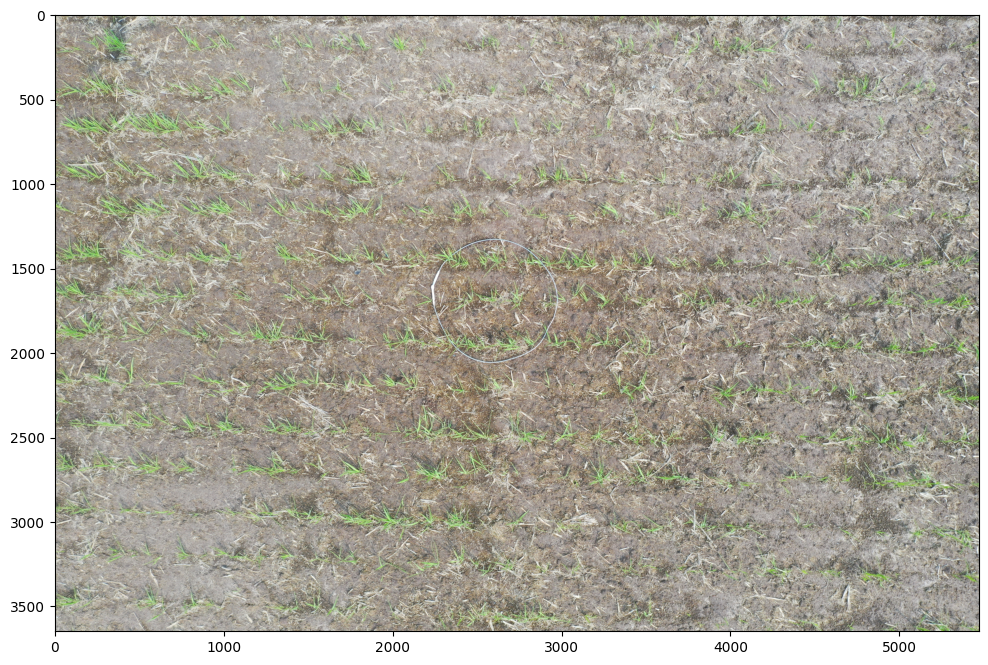

In [493]:
image = cv.imread(image_file)

im = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

In [494]:
H, W, _ = im.shape
im.shape
#(height, width, channels) 

(3648, 5472, 3)

# División en Tiles

**Objetivo:** Dividir la imagen en mosaicos de 240x240px

In [495]:
# Definido al inicio (proceso en bache)
#S = 240 # Tile size 

In [496]:
ROWS = math.ceil(H/S) # Rows
COLUMNS = math.ceil(W/S) # Columns
ROWS, COLUMNS

(6, 9)

In [497]:
print("Se dividirá la imagen en {:,} tiles".format(ROWS * COLUMNS))

Se dividirá la imagen en 54 tiles


## Agrega borde negro para ajustar las dimensiones

In [498]:
# Dimensiones del archivo original en px
im.shape

(3648, 5472, 3)

In [499]:
center = True

if center:
    # Centra la imagen y agrega alrededor un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, math.floor((S * ROWS - H)/2), math.ceil((S * ROWS - H)/2),
                                math.floor((S * COLUMNS - W)/2),  math.ceil((S * COLUMNS - W)/2),
                                cv.BORDER_CONSTANT, (0,0,0)
                               )
    # Calcular offset por redimensión de la imagen
    y_offset = math.floor((S * ROWS - H)/2)
    x_offset = math.floor((S * COLUMNS - W)/2)
    
else:
    # Agrega al final de la imagen un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, 0, (S * ROWS - H), 0, (S * COLUMNS - W), cv.BORDER_CONSTANT, (0,0,0))
    
    # Informa que no existe offset en la imagen
    x_offset = 0
    y_offset = 0

In [500]:
x_offset, y_offset

(144, 96)

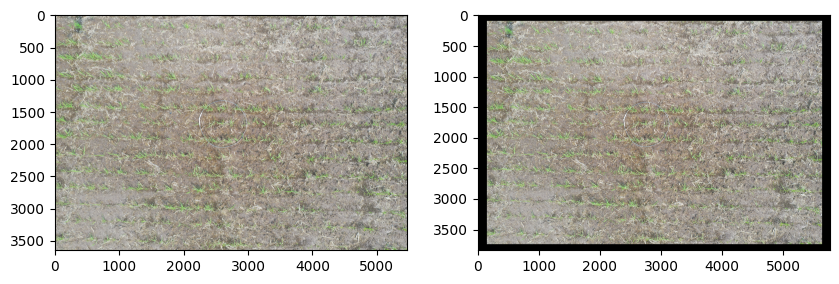

In [501]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(im_fill)
plt.show()

In [502]:
# Se verifica que la división en tiles da un entero
a, b, _ = im_fill.shape
a/S, b/S

(6.0, 9.0)

In [503]:
# Dimensiones del archivo en px (con borde negro)
im_fill.shape

(3840, 5760, 3)

## Realiza la división en mosaicos

In [504]:
tiles = [[0] * COLUMNS for _ in range(ROWS)]
tiles_dim = [[0] * COLUMNS for _ in range(ROWS)]
x0, x1, y0, y1 = 0, 0, 0, 0
count = 0

for row in range(ROWS):  # Filas primero
    for column in range(COLUMNS):  # Luego columnas
        x0 = S * column  # Basado en la columna
        y0 = S * row  # Basado en la fila
        x1 = S * (column + 1)
        y1 = S * (row + 1)
        
        # Ahora ambos tienen el mismo orden de indices
        tiles[row][column] = im_fill[y0:y1, x0:x1] # Corta la imágen en mosaicos
        tiles_dim[row][column] = (x0, y0, x1, y1) # Almacena la grilla de dimensiones
        
        count += 1

timestamp()

Timestamp: 2025-03-10 00:26:56


In [505]:
#Se verifica que las dimensiones de la lista coinciden con las de los tiles deseados
print("     ","rows", "cols")
print("tiles:", len(tiles),",", len(tiles[0]))
print("dims: ", len(tiles_dim),",", len(tiles_dim[0]))

      rows cols
tiles: 6 , 9
dims:  6 , 9


In [506]:
tiles_dim[1][0] # crece horizonalmente

(0, 640, 640, 1280)

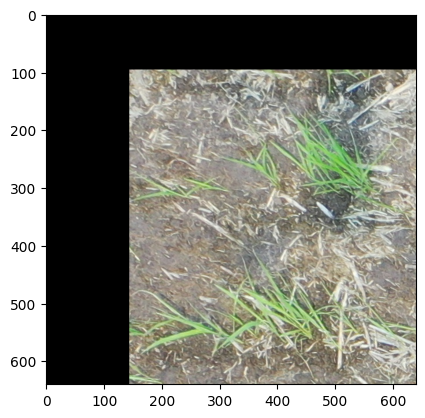

In [507]:
#rows, columns (y, x)
plt.imshow(tiles[0][0]) # crece verticalmente

# Exportación de la imagen dividida

## Almacenamiento de imágenes

In [525]:
# Creates mested function for generating every tile filename iteratively
generate_tile_filename = filenames_for_tiles(dset=SUBSET, 
                                             dtype='image',
                                             dir='out', 
                                             name=PROCESSING_FILE)

In [526]:
# Guarda las imágenes con manejo de errores
try:
    for row in range(ROWS):
        for column in range(COLUMNS):
            # Creation of filename for current tile
            tile_prefix = f"tile{row:02d}x{column:02d}"
            name = generate_tile_filename(tile_prefix)
            
            # Preparation of data to store
            index = get_index(row,column)
            data = tiles[row][column]

            # Check if the tile data is valid (e.g., not None)
            if data is None:
                print(f"⚠️ Tile data is None for {name}, skipping.")
                continue  # Skip to the next tile

            # Convert from RGB to BGR if necessary
            if data.shape[2] == 3: # Check if it has 3 channels (color image)
                file_data = cv.cvtColor(data, cv.COLOR_RGB2BGR)
            else:
                file_data = data # If it's grayscale, no conversion needed

            success = cv.imwrite(name,file_data)
            
            if not success:
                file_name = name[(name.find('images'))+7:]
                print(f"🚫 Error al guardar:\n {file_name}")
                
except Exception as e:
    print(f"❌ Error inesperado: {e}")
else:
    print("✅ Todas las imágenes se guardaron correctamente.")
    timestamp()

✅ Todas las imágenes se guardaron correctamente.
Timestamp: 2025-03-10 00:37:14
